# OS-Atlas Tutorial with FiftyOne

This tutorial demonstrates how to use the OS-Atlas vision-language models with FiftyOne as a vision-language-action model designed for GUI agents.

## 1. Load a Sample Dataset

First, let's load a small UI dataset from the FiftyOne Hugging Face org.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import fiftyone.utils.huggingface as fouh

dataset = fouh.load_from_hub(
    "Voxel51/GroundUI-18k",
    overwrite=True,
    max_samples=200,
    )

Loading dataset
Importing samples...
 100% |█████████████████| 200/200 [5.8ms elapsed, 0s remaining, 34.6K samples/s]       


In [ ]:
# if you've already downloaded this dataset you can load it via:

# import fiftyone as fo
# import fiftyone.zoo as foz

# dataset = fo.load_dataset("Voxel51/GroundUI-18k")

Launch the FiftyOne App to visualize the dataset (optional)

In [ ]:
fo.launch_app(dataset)

## 2. Set Up OS-Atlas Integration

Register the OS-Atlas remote zoo model source and load the model.

In [2]:
import fiftyone.zoo as foz

# Register the model source
foz.register_zoo_model_source("https://github.com/harpreetsahota204/os_atlas", overwrite=True)

  151.4Kb [48.0ms elapsed, ? remaining, 3.1Mb/s] 
Overwriting existing model source '/home/harpreet/fiftyone/__models__/'


# Load the OS-Atlas model


In [ ]:
model = foz.load_zoo_model(
    "OS-Copilot/OS-Atlas-Base-7B", # you could also use "OS-Copilot/OS-Atlas-Pro-7B"
    install_requirements=True, # you can pass this to make sure you have all reqs installed
    )

Note that for any of the following operations you can use a Field which currently exists on your dataset, all you need to do is pass the name of that field in `prompt_field` when you call `apply_model`. For example:

```python
dataset.apply_model(model, prompt_field="<field-name>", label_field="<label-field>")
```

## 3. Visual Question Answering

Ask the model to describe UI screenshots.

In [4]:
model.operation = "vqa"
model.prompt = "Describe this screenshot and what the user might be doing in it."
dataset.apply_model(model, label_field="vqa_results")

 100% |█████████████████████| 5/5 [18.1s elapsed, 0s remaining, 0.3 samples/s]   


In [5]:
dataset.first()['vqa_results']

'The screenshot shows a webpage from the BabyCenter website, specifically a section of the Registry Builder tool. The user appears to be in the process of creating or updating a baby registry. The page displays a message indicating that the user has completed a step and is prompted to answer one more question before the recommended registries are finalized. There is a button labeled "KEEP GOING!" which suggests that the user can proceed to the next step in the registry creation process.'

Straightforward "read the text" style OCR:

In [6]:
model.prompt = "Read the text on this screenshot"
dataset.apply_model(model, label_field="plain_ocr")

 100% |█████████████████████| 5/5 [18.5s elapsed, 0s remaining, 0.3 samples/s]   


In [7]:
dataset.first()['plain_ocr']

'The text on the screenshot reads:\n\n"You got it!\nJust one more question before your recommended registries.\nDon\'t forget to come back to Registry Builder later to sync them all in one place.\nKEEP GOING!"'

## 4. Grounded Optical Character Recognition (OCR)

Extract and locate text in the UI.

Note: This will take a VERY LONG time!

In [ ]:
model.operation = "ocr"
model.prompt = "Read the text for each UI element in this interface only once. Focus on text in toolbars, buttons, menus, and other controls. Do not read the same text more than once."
dataset.apply_model(model, label_field="ocr_results")

In [9]:
dataset.first()['ocr_results']

<Detections: {
    'detections': [
        <Detection: {
            'id': '6868174de8fbb96d55002c94',
            'attributes': {},
            'tags': [],
            'label': 'menu',
            'bounding_box': [0.0, 0.029, 0.034, 0.045],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
            'text': 'Menu',
        }>,
        <Detection: {
            'id': '6868174de8fbb96d55002c95',
            'attributes': {},
            'tags': [],
            'label': 'title',
            'bounding_box': [0.399, 0.01, 0.201, 0.061],
            'mask': None,
            'mask_path': None,
            'confidence': None,
            'index': None,
            'text': 'babycenter',
        }>,
        <Detection: {
            'id': '6868174de8fbb96d55002c96',
            'attributes': {},
            'tags': [],
            'label': 'button',
            'bounding_box': [0.922, 0.029, 0.033, 0.045],
            'mask': 

## 5. Keypoint Detection

Identify important points in the UI.

In [ ]:
model.operation = "point"

dataset.apply_model(
    model,
    prompt_field="instruction", # using a field from the dataset
    label_field="ui_keypoints"
    )

In [11]:
dataset.first()['ui_keypoints']

<Keypoints: {
    'keypoints': [
        <Keypoint: {
            'id': '68681831e8fbb96d55002ced',
            'attributes': {},
            'tags': [],
            'label': 'KEEP GOING! button',
            'points': [[0.4, 0.832]],
            'confidence': None,
            'index': None,
        }>,
    ],
}>

## 6. Classification

Classify the type of UI platform.

In [ ]:
model.operation = "classify"
model.prompt = "Classify this UI as coming from one of the following operating systems: android, ios, windows, macos, linux, chromeos, or other"
dataset.apply_model(model, label_field="ui_classifications")

In [13]:
dataset.first()['ui_classifications']

<Classifications: {
    'classifications': [
        <Classification: {
            'id': '68681838e8fbb96d55002cf2',
            'tags': [],
            'label': 'web browser',
            'confidence': None,
            'logits': None,
            'thought': 'The website is designed for a web browser interface.',
        }>,
    ],
    'logits': None,
}>

If your dataset has a field that you want to extract labels from to perform zero-shot classification, you can do so with the following code:

In [14]:
classes = dataset.distinct("platform")

You can then use this as part of your prompt:

In [ ]:
model.prompt = f"Which of the following websites is this screenshot from? Pick from exactlt one of the following: {classes}"
dataset.apply_model(model, label_field="app_classifications")

In [16]:
dataset.first()['app_classifications']

<Classifications: {
    'classifications': [
        <Classification: {
            'id': '6868183fe8fbb96d55002cf7',
            'tags': [],
            'label': 'web',
            'confidence': None,
            'logits': None,
            'thought': 'The website is a web-based platform.',
        }>,
    ],
    'logits': None,
}>

## 7. Agentic

In this dataset, there's an `instruction` field that contains instructions for an agent.

In [ ]:
# If your dataset has a field called "instruction" with instructions
model.operation = "agentic"
dataset.apply_model(model, prompt_field="instruction", label_field="agentic_output")

In [18]:
dataset.first()['agentic_output']

<Keypoints: {
    'keypoints': [
        <Keypoint: {
            'id': '68681846e8fbb96d55002cfc',
            'attributes': {},
            'tags': [],
            'label': 'click',
            'points': [[0.432, 0.844]],
            'confidence': None,
            'index': None,
            'metadata': {
                'sequence_idx': 0,
                'action': 'click',
                'thought': "click on the 'KEEP GOING!' button",
            },
        }>,
    ],
}>

# 8. Detection

In [ ]:
# If your dataset has a field called "instruction" with instructions
model.operation = "detect"
dataset.apply_model(model, prompt_field="instruction", label_field="detect_output")

In [ ]:
dataset.first()['detect_output']

## 8. Set your own system prompts

You can set your own system prompts for the model for any of the operations.

In [ ]:
# first, clear the system prompt
model.system_prompt = None

#then set your custom system prompt

model.system_prompt = "Your awesome custom system prompt!"

## 9. View Results



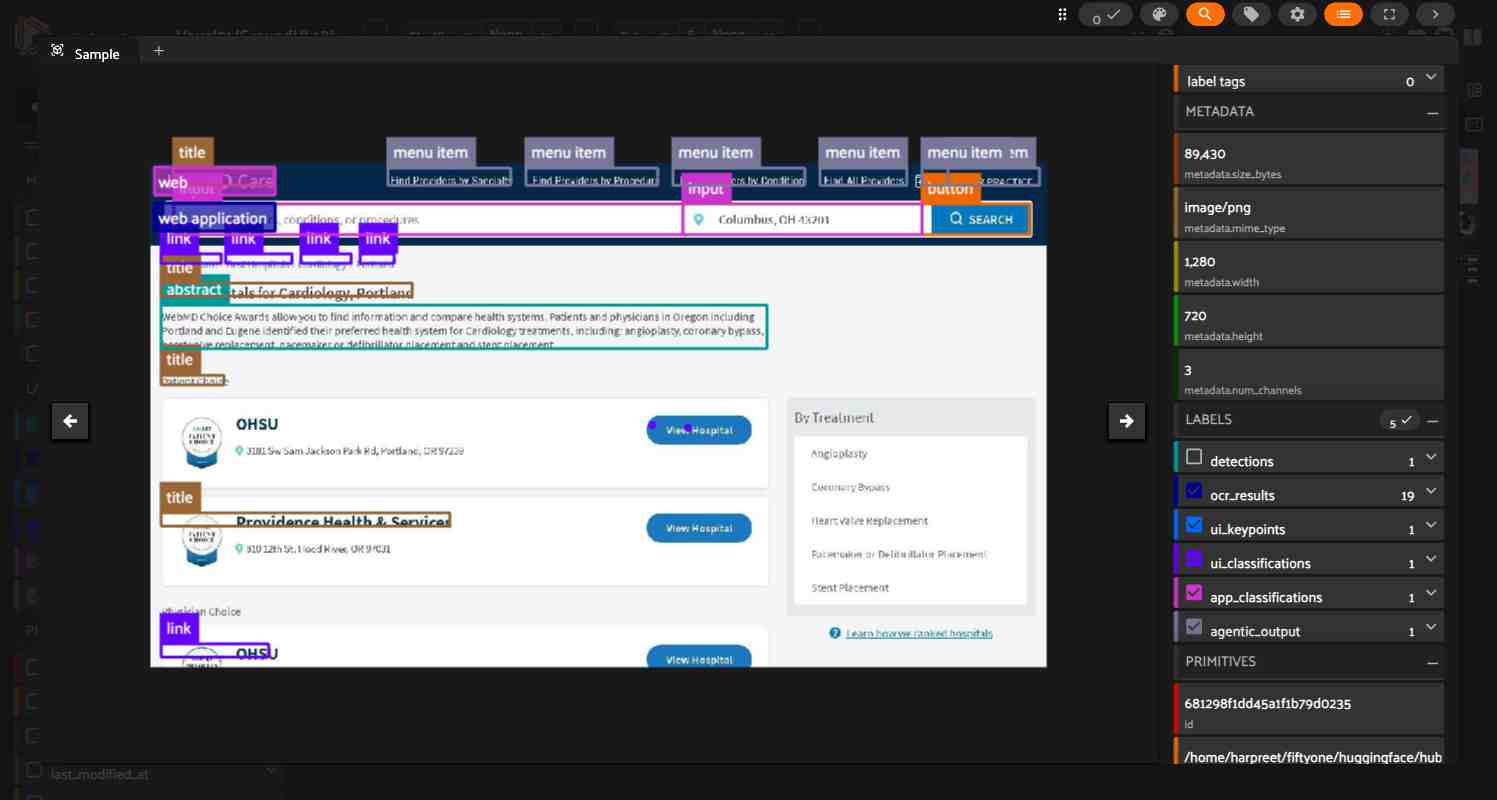

In [22]:
# Visualize all results in the FiftyOne App
session = fo.launch_app(dataset)

In [23]:
session.freeze()